# Compare SED for different ages at different t_obs or redshifts

- author : Sylvie Dagoret-Campagne
- creation date : 2023/10/05
- last update : 2023/10/05

https://dsps.readthedocs.io/en/latest/dsps_quickstart.html

This demo notebook begins by downloading the DSPS default option for the SSP spectral library. These data are stored at this URL in a flat hdf5 file with column names as expected by the dsps.load_ssp_templates function, which we will demonstrate below.

When downloading and storing SSP libraries, you can optionally use the DSPS_DRN environment variable to specify the default location where DSPS will look for SSP libraries. But here we’ll just save the downloaded data to tempdata.h5, directly pass the filename to the data loader. The load_ssp_templates that we’ll use to load these SSPs is just a convenience function - all of the DSPS functions that we’ll demonstrate in this notebook accept plain arrays and floats as inputs, and so you can store your SSP data on disk in whatever format you like.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.backends.backend_pdf import PdfPages
import copy

In [2]:
import numpy as np

## Inspect the SSP data¶

In [3]:
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_fsps_v3.2_lgmet_age.h5 > tempdata.h5
#! curl https://portal.nersc.gov/project/hacc/aphearin/DSPS_data/ssp_data_continuum_fsps_v3.2_lgmet_age.h5 > tempdata_v2.h5

In [4]:
from dsps import load_ssp_templates
#ssp_data = load_ssp_templates(fn='tempdata_v2.h5')
ssp_data = load_ssp_templates(fn='tempdata.h5')

print(ssp_data._fields)

print('\nssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

2023-10-05 11:04:06.549590: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')

ssp_lgmet.shape = (12,)
ssp_lg_age_gyr.shape = (107,)
ssp_wave.shape = (5994,)
ssp_flux.shape = (12, 107, 5994)


In [5]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY

In [6]:
ssp_data.ssp_lgmet

array([-4.34771165, -3.84771165, -3.59771165, -3.34771165, -3.09771165,
       -2.84771165, -2.59771165, -2.34771165, -2.09771165, -1.84771165,
       -1.59771165, -1.34771165])

In [7]:
ssp_data.ssp_lg_age_gyr

array([-4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 , -3.65, -3.6 ,
       -3.55, -3.5 , -3.45, -3.4 , -3.35, -3.3 , -3.25, -3.2 , -3.15,
       -3.1 , -3.05, -3.  , -2.95, -2.9 , -2.85, -2.8 , -2.75, -2.7 ,
       -2.65, -2.6 , -2.55, -2.5 , -2.45, -2.4 , -2.35, -2.3 , -2.25,
       -2.2 , -2.15, -2.1 , -2.05, -2.  , -1.95, -1.9 , -1.85, -1.8 ,
       -1.75, -1.7 , -1.65, -1.6 , -1.55, -1.5 , -1.45, -1.4 , -1.35,
       -1.3 , -1.25, -1.2 , -1.15, -1.1 , -1.05, -1.  , -0.95, -0.9 ,
       -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 , -0.55, -0.5 , -0.45,
       -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,
        0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ])

The returned ssp_data is a namedtuple storing 4 ndarrays for the age-metallicity grid of the SSP spectra. Galaxy SEDs are calculated via probability-weighted sums of these spectral templates. For a galaxy observed at some, we’ll calculate the restframe SED of two different models in the cells below:

    a galaxy with a tabulated star formation history (SFH), and metallicity Z distributed as a lognormal about some median Z, using the calc_rest_sed_sfh_table_lognormal_mdf function.

    a galaxy with SFH table and also tabulated history of metallicity (ZH), using the calc_rest_sed_sfh_table_met_table function.

In the cells below, we’ll randomly generate an SFH and ZH for a galaxy, and then plot the results.

## Explore L_SPS

In [8]:
# two mutually exclusive flags to see if we can provide SFR for t> tobs
# both flags can be True of False at the same time, but no selection on tobs will be done
FLAG_CUT_BELOW_TOBS = False
FLAG_CUT_AFTER_TOBS = True
FLAG_SET_YLIM = False

In [9]:
import numpy as np
# table of ages in 100 bins in linear scale from 50 millions to 13.8 billions years
gal_t_table = np.linspace(0.05, 13.8, 100) # age of the universe in Gyr

# must put a true SFR using package diffstar
gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr

# metallicity
gal_lgmet = -1.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

gal_lgmet_table = np.zeros(len(gal_t_table)) + gal_lgmet

In [10]:
NBSPECTRA = len(gal_t_table)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)

The SED calculating functions require you specify the time of the observation, t_obs, rather than the redshift, z_obs. We’ll use the age_at_z function in dsps.cosmology to calculate the relationship between these two quantities, assuming the default redshift of DSPS. You could also use this same function to compute gal_t_table in case your input SFH is tabulated as a function of redshift.

In [11]:
# defining the list of redshits/tobs
all_redshifts = [0., 0.1, 0.5, 1.0, 3., 5.]

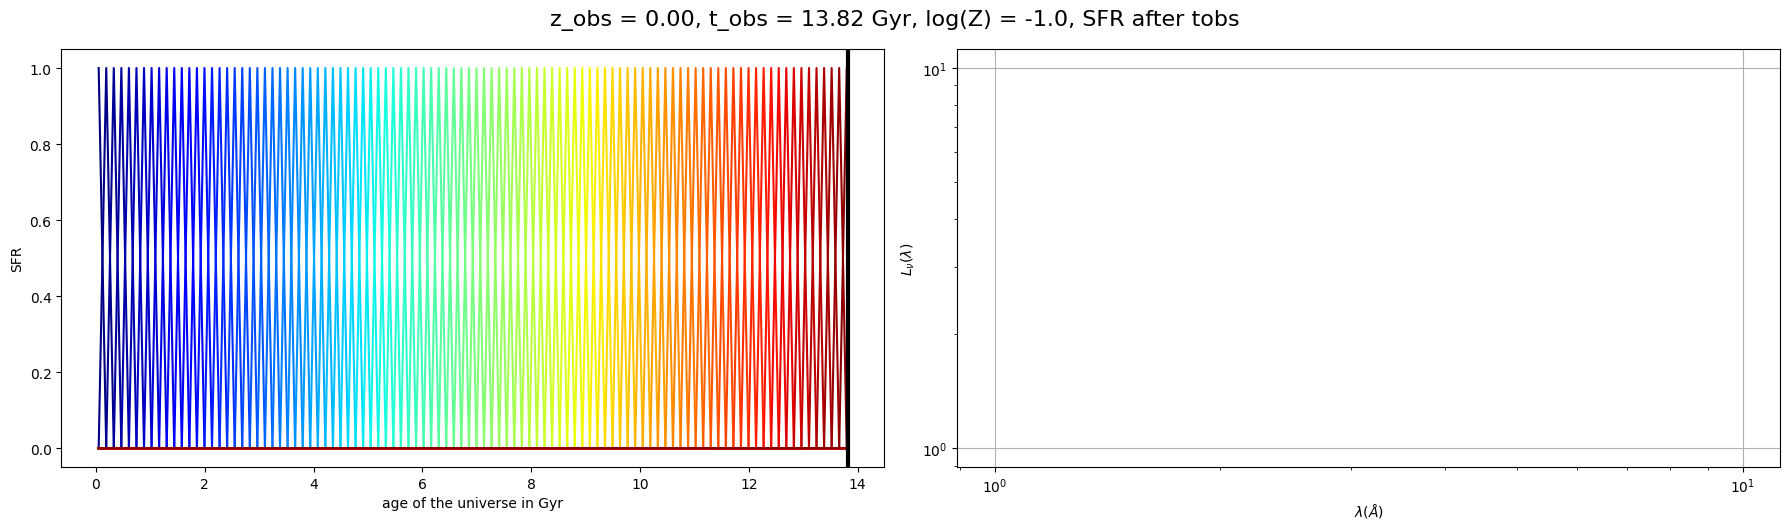

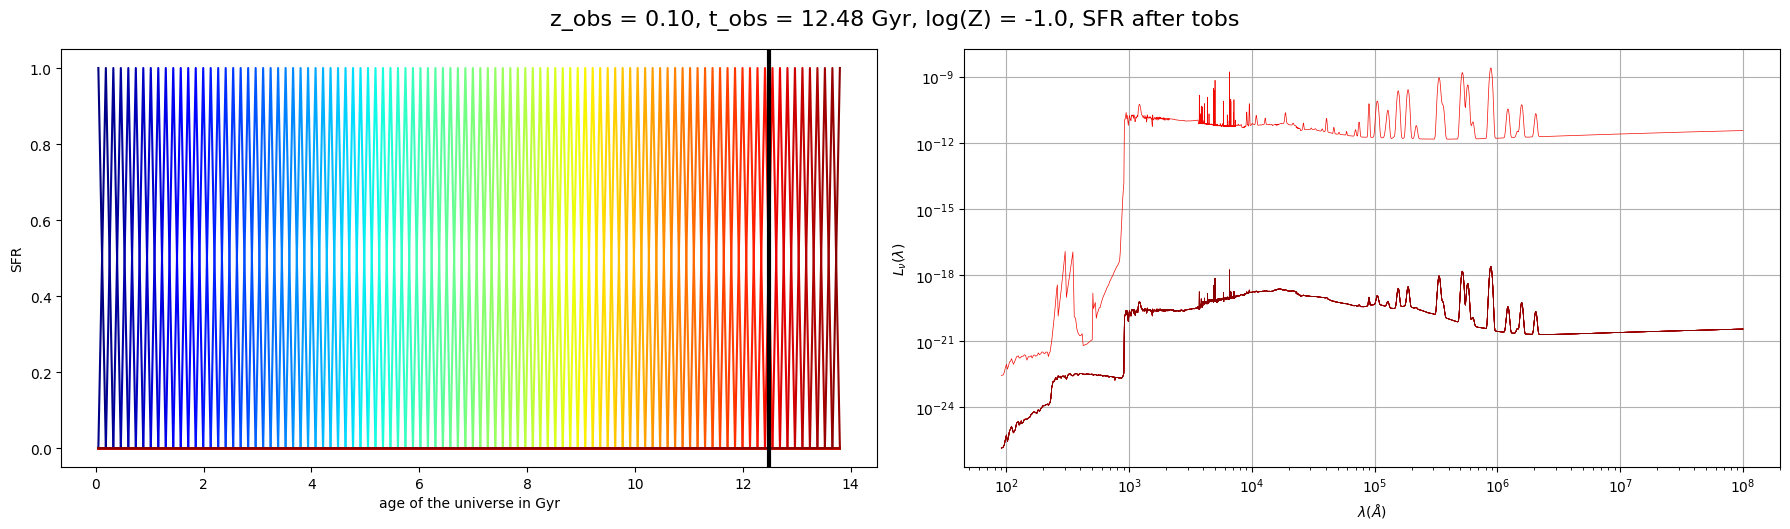

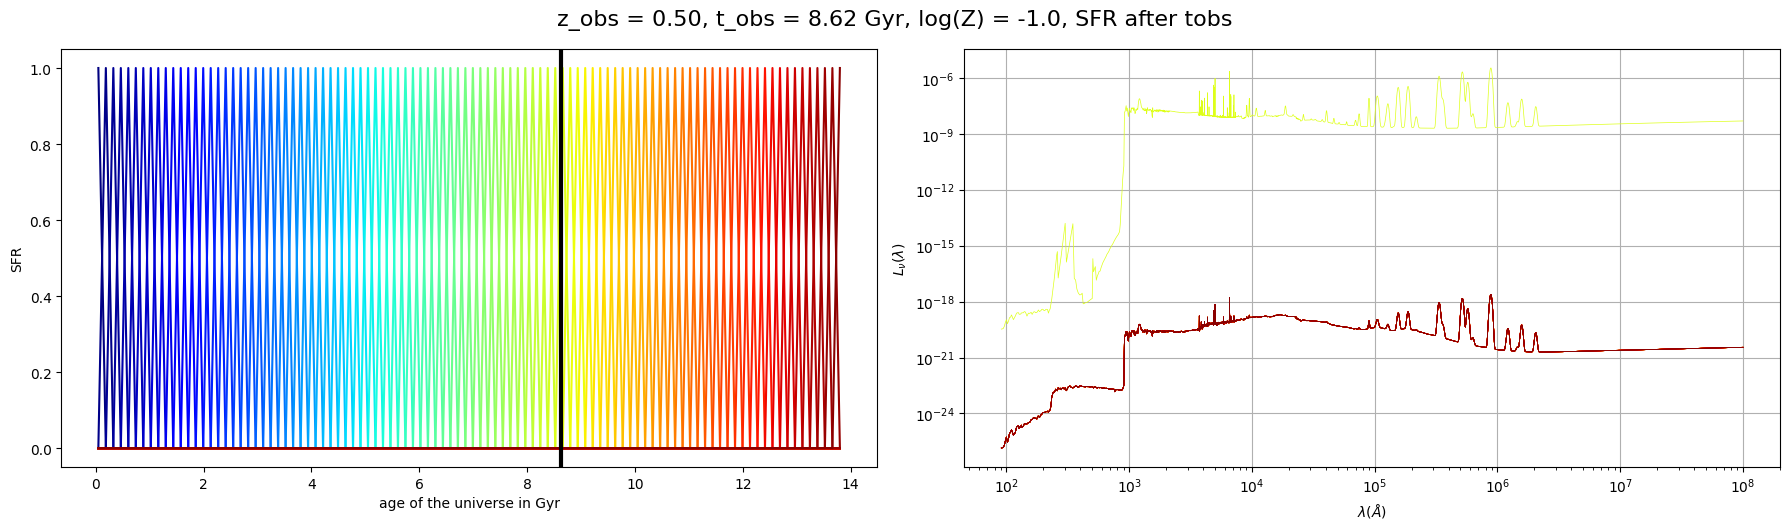

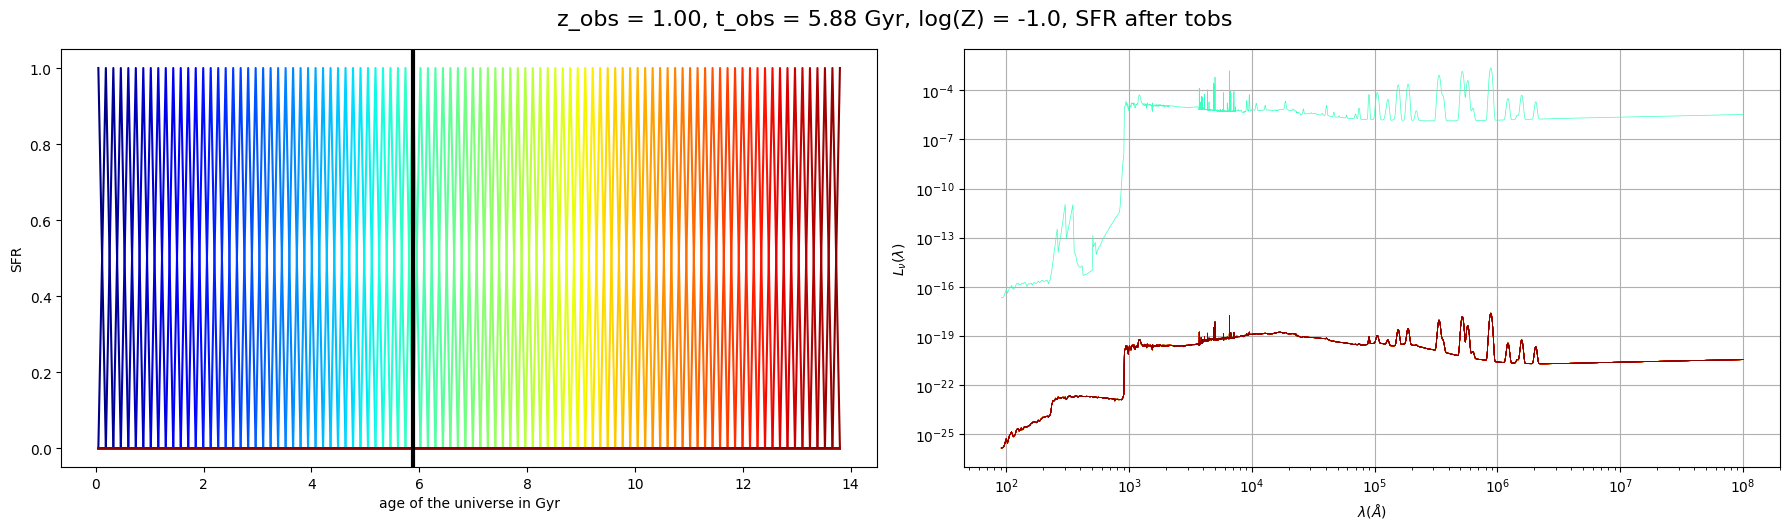

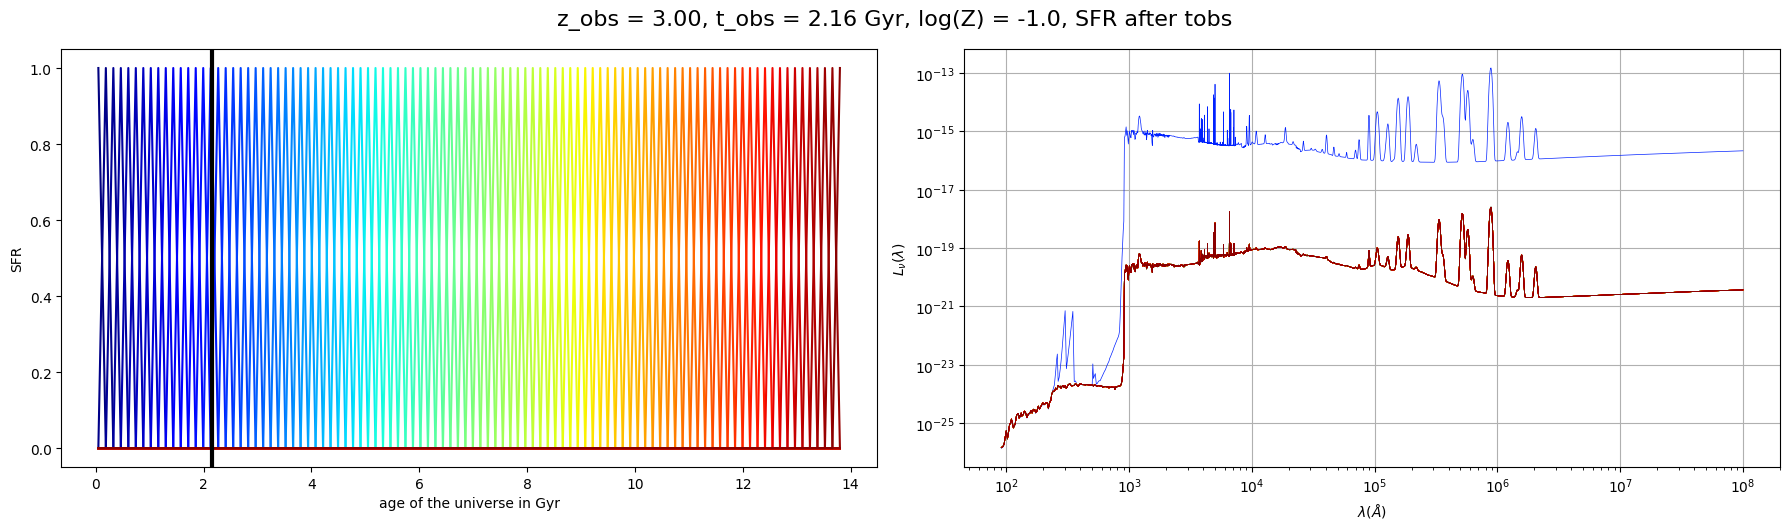

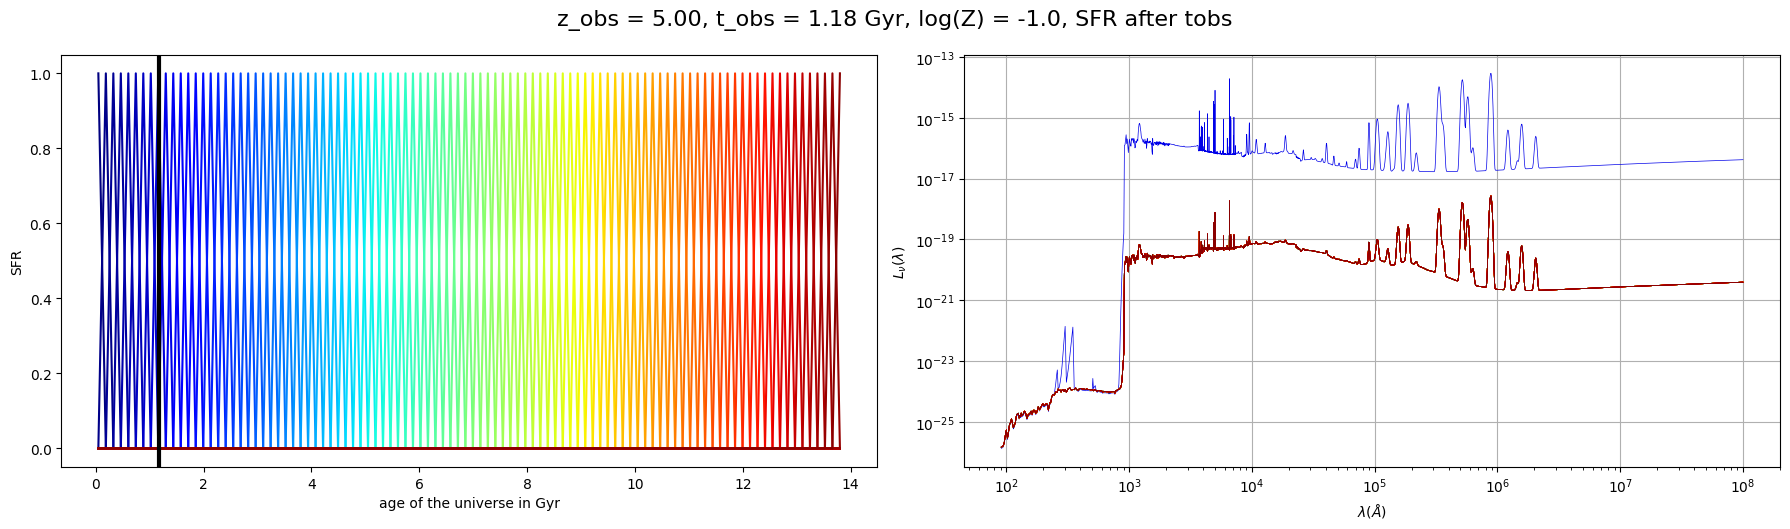

In [12]:
# empty containers to start
all_sedinfos_for_allredshifts = []
all_sedinrestframe_for_allredshifts = []
all_sedtitles_for_allredshifts = []
all_sedtobs = []


for redshift in all_redshifts:
    
    # info
    # =====
    z_obs = redshift
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    
    if FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before tobs"
    elif FLAG_CUT_AFTER_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR after tobs"
    elif FLAG_CUT_AFTER_TOBS ==  FLAG_CUT_BELOW_TOBS:
        the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet}, SFR before and after tobs"
    
    # save title and tobs for that redshift
    all_sedtitles_for_allredshifts.append(the_title)
    all_sedtobs.append(t_obs)
    
    # Compute spectra
    # ==============
    all_sed_infos  = []
    all_sfr = []

    # loop on ages
    for idx,time in enumerate(gal_t_table):
              
            
        #gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr
        gal_sfr_table[idx] = 1.0
    
        all_sfr.append(copy.deepcopy(gal_sfr_table))
    
        sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
        gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
        all_sed_infos.append(sed_info) 
    
        sed_info2 = calc_rest_sed_sfh_table_met_table(
        gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
        gal_sfr_table[idx] = 0.0
    
    # Save all SED infos for that redshift
    all_sedinfos_for_allredshifts.append(copy.deepcopy(all_sed_infos))
    
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(18,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")
    ax1.axvline(t_obs,color="k",lw=3)

    ax2=axs[1]
    __=ax2.loglog()
    
    all_sedinrestframe = []
    for idx,time in enumerate(gal_t_table):
        if FLAG_CUT_BELOW_TOBS and time < t_obs:
            ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
            all_sedinrestframe.append(copy.deepcopy(all_sed_infos[idx].rest_sed))
        elif FLAG_CUT_AFTER_TOBS and time > t_obs:
            ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
            all_sedinrestframe.append(copy.deepcopy(all_sed_infos[idx].rest_sed))
        elif FLAG_CUT_BELOW_TOBS == FLAG_CUT_AFTER_TOBS:
            ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
            all_sedinrestframe.append(copy.deepcopy(all_sed_infos[idx].rest_sed))
    
    # save all SEDs at all tobs for that redshift
    all_sedinrestframe_for_allredshifts.append(all_sedinrestframe)
    
    if FLAG_SET_YLIM:
        ax2.set_ylim(1e-12,1e-5)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.05,fontsize=16)
    

In [13]:
all_sedtobs

[DeviceArray(13.821265, dtype=float32),
 DeviceArray(12.477264, dtype=float32),
 DeviceArray(8.624905, dtype=float32),
 DeviceArray(5.8796177, dtype=float32),
 DeviceArray(2.1572857, dtype=float32),
 DeviceArray(1.1792068, dtype=float32)]

In [14]:

def SaveFigSpectraInPdf(nbspecperpage=6):
    
    Nspec= len(all_redshifts) # also all_sedinfos_for_allredshifts
    
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    # loop on redshifts
    for index in range(Nspec): 
        
        idx = index
        t_obs = all_sedtobs[idx]
        print(index,t_obs)
        
        # get index on spectrum
        textstr = all_sedtitles_for_allredshifts[idx]
        #all_sed_inrestframe = all_sedinrestframe_for_allredshifts[idx]
        all_sedinfos = all_sedinfos_for_allredshifts[idx]
   
        # if we need to start a new page
        if idx_inpage == nbspecperpage:
            idx_inpage = 1  # start at the first row in the page from 1 to nbspecperpage
            idx_pagenum += 1  # increase page counter
            
            # this trigger the saving of the whole figure (including all spectra of the page)
            if idx_pagenum > 1:
                plt.show()
                all_composed_figs.append(fig)
            
            # this create a new page of figure 
            fig=plt.figure(figsize=(18,20))
            
        
            
        # this is not a new page, need to increase the row number inside this page from 1 to nbspecperpage    
        else:
            idx_inpage += 1   
        
        # index of the figure in the page
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {index}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
    
       
        
        # left image, two columns
        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
        # loop on all ages
        for idx1,time in enumerate(gal_t_table):
            ax1.plot(gal_t_table, all_sfr[idx1],"-",color=all_colors[idx1])
        ax1.set_xlabel("age of the universe in Gyr")
        ax1.set_ylabel("SFR")
        ax1.axvline(all_sedtobs[index],color="k",lw=3)

    
        #right image, to columns
        
        # Get the spectrum info for that redshift         
        #all_sedinfos = all_sedinfos_for_allredshifts[index]
        label =  all_sedtitles_for_allredshifts[index]
        
        
        
        
        ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
        
        __=ax2.loglog()
    
        # loop on ages
        for idx1,time in enumerate(gal_t_table):
                
            if FLAG_CUT_BELOW_TOBS and time < t_obs:
                ax2.plot(ssp_data.ssp_wave, all_sedinfos[idx1].rest_sed,"-",color=all_colors[idx1],lw=0.5)
            elif FLAG_CUT_AFTER_TOBS and time > t_obs:
                ax2.plot(ssp_data.ssp_wave, all_sedinfos[idx1].rest_sed,"-",color=all_colors[idx1],lw=0.5)
            elif FLAG_CUT_BELOW_TOBS  == FLAG_CUT_AFTER_TOBS:
                ax2.plot(ssp_data.ssp_wave, all_sedinfos[idx1].rest_sed,"-",color=all_colors[idx1],lw=0.5)
            
        if FLAG_SET_YLIM:
            ax2.set_ylim(1e-12,1e-5)
        
        ax2.grid()
        ax2.set_xlabel("$\lambda (\\AA)$")
        ax2.set_ylabel("$L_\\nu(\lambda)$")
        ax2.set_title(label)
        
             
    all_composed_figs.append(fig)                       
    return  all_composed_figs
    

0 13.821265
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/2.0, idx_inpage = 1, idx_fig = 1
1 12.477264
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/2.0, idx_inpage = 2, idx_fig = 3
2 8.624905
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/2.0, idx_inpage = 3, idx_fig = 5
3 5.8796177
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/2.0, idx_inpage = 4, idx_fig = 7
4 2.1572857


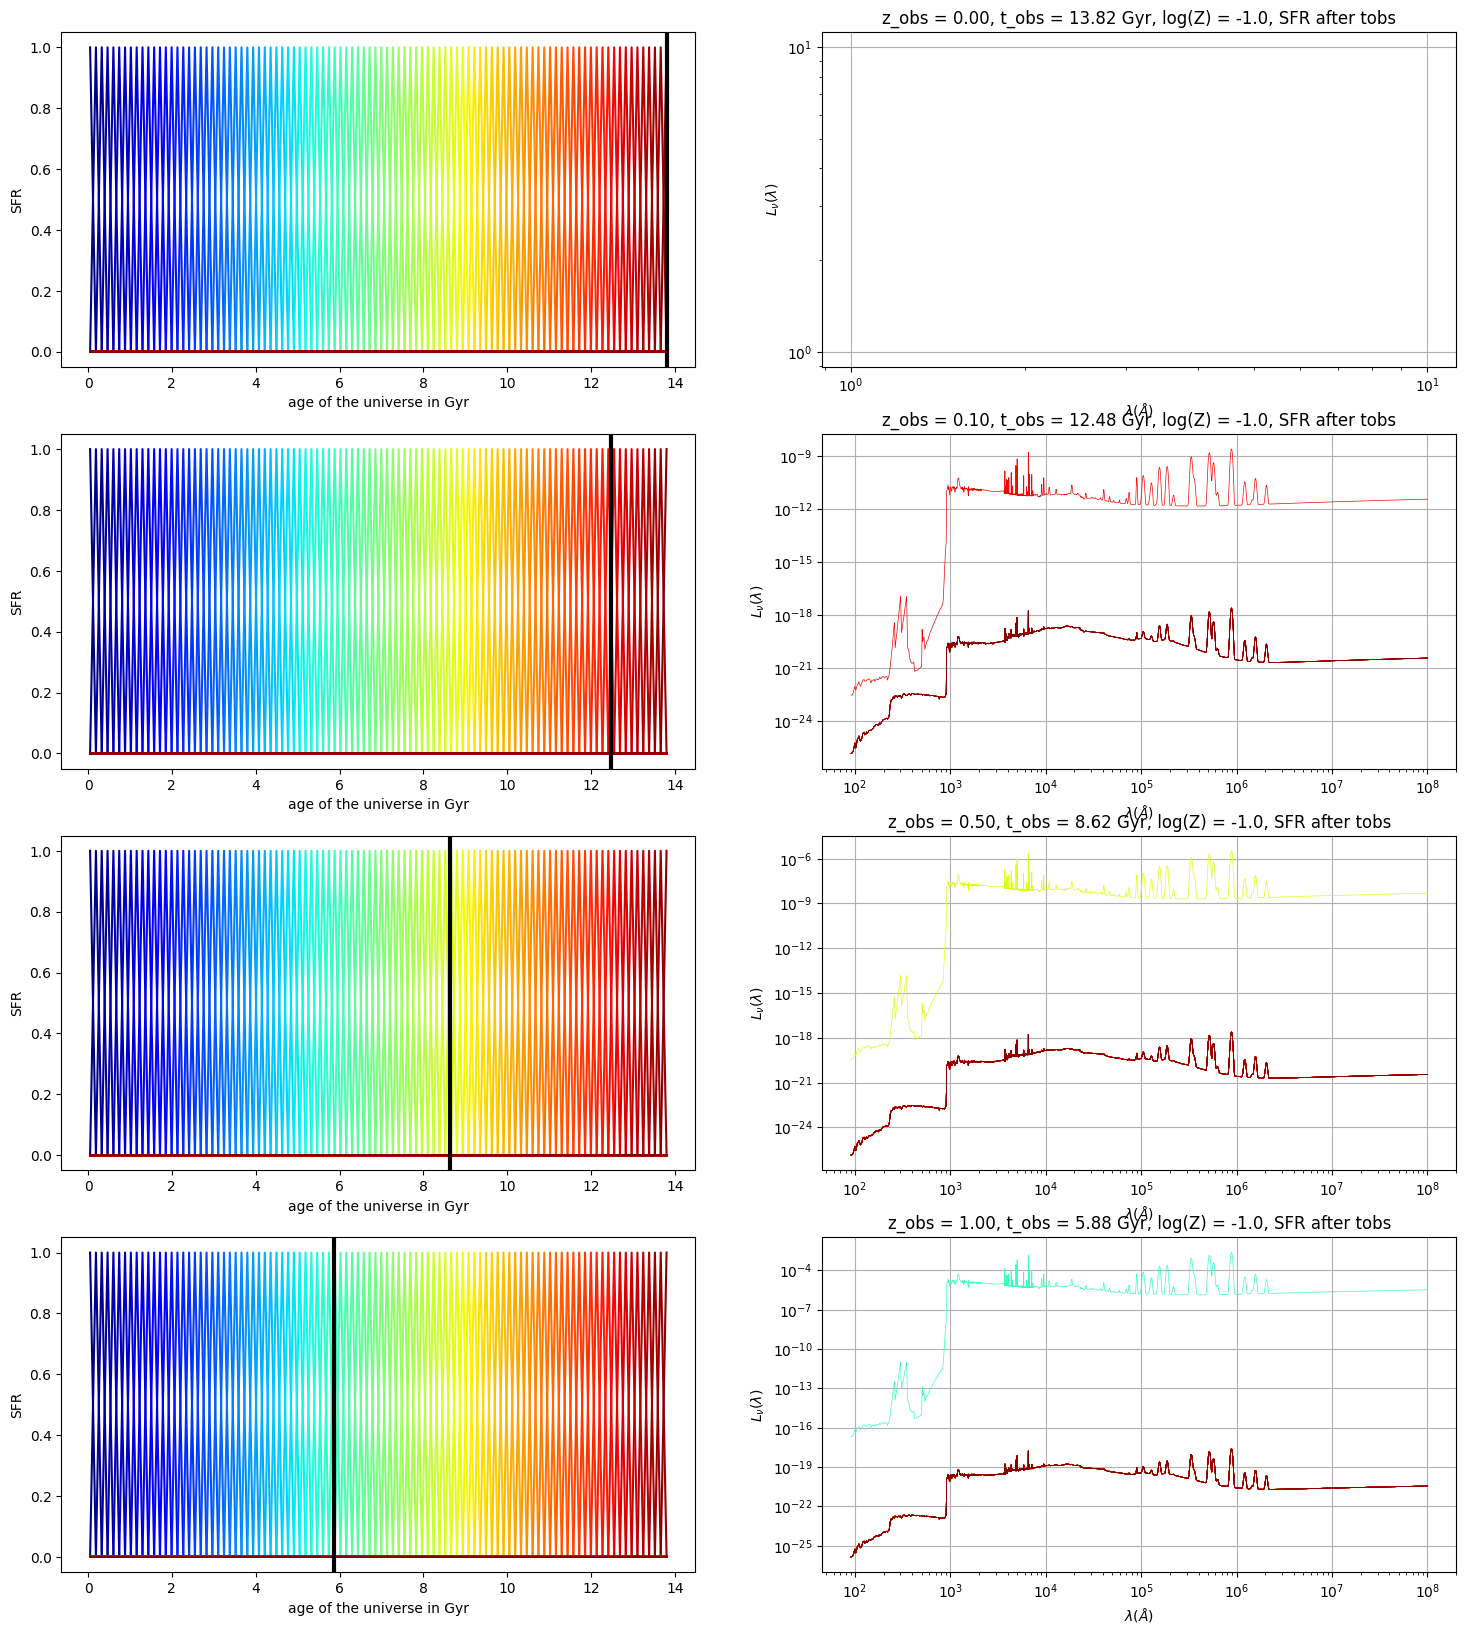

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 2/2.0, idx_inpage = 1, idx_fig = 1
5 1.1792068
	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/2.0, idx_inpage = 2, idx_fig = 3


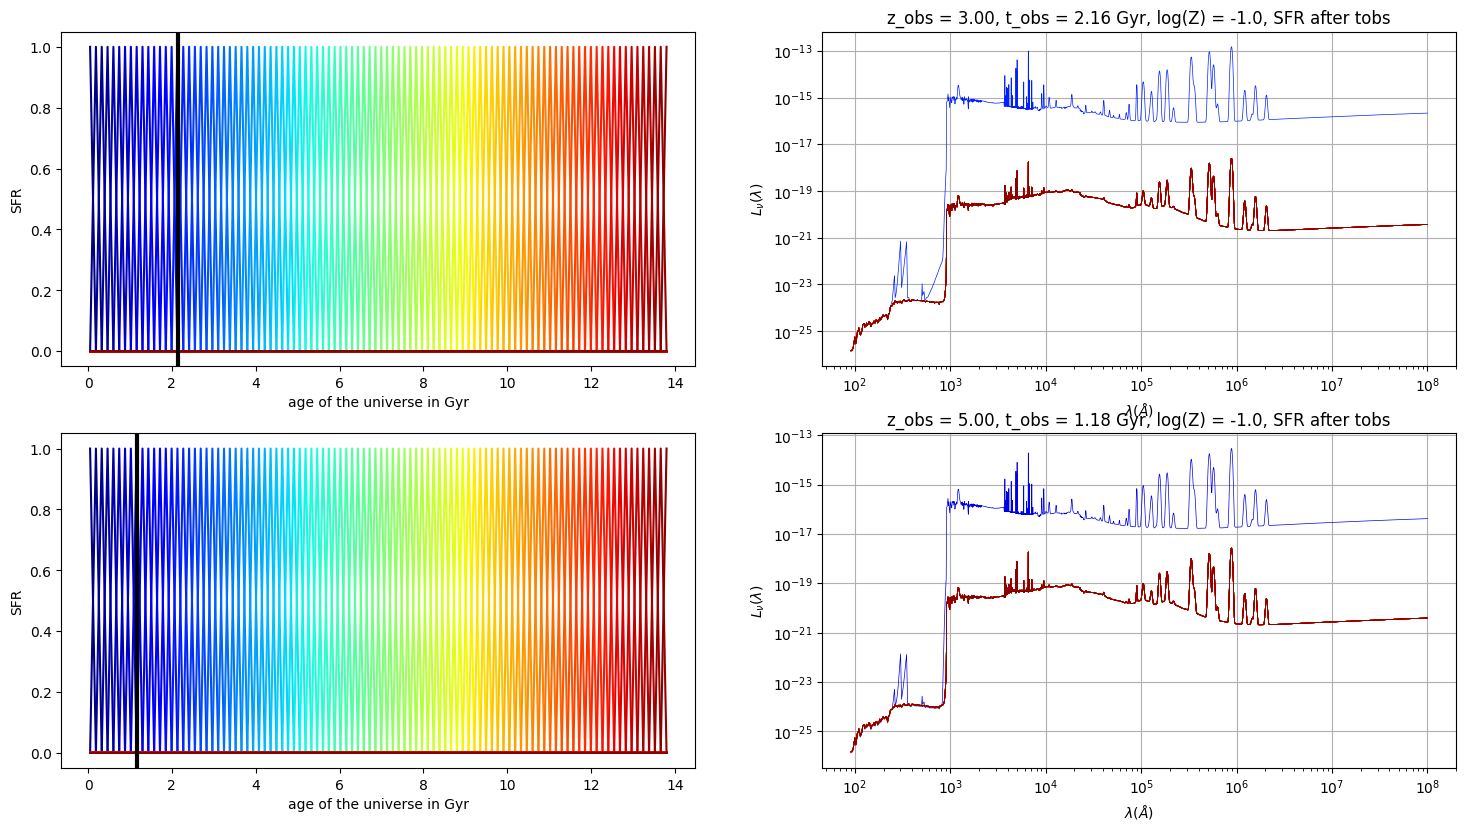

In [15]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=4)

In [16]:
if FLAG_CUT_BELOW_TOBS:
    multipage_pdf_file = f'multipage_pdf_galaxyspectra_sfrbeforetobs.pdf'
elif FLAG_CUT_AFTER_TOBS:
    multipage_pdf_file = f'multipage_pdf_galaxyspectra_sfraftertobs.pdf'
elif FLAG_CUT_BELOW_TOBS == LAG_CUT_AFTER_TOBS:
    multipage_pdf_file = f'multipage_pdf_galaxyspectra_sfrbeforeandaftertobs.pdf'


In [17]:
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [18]:
all_figs

[<Figure size 1800x2000 with 8 Axes>, <Figure size 1800x2000 with 4 Axes>]

In [19]:
assert False

AssertionError: 

# Do not cut on tobs

In [ ]:
# empty containers to start
all_sedinfos_for_allredshifts = []
all_sedinrestframe_for_allredshifts = []
all_sedtitles_for_allredshifts = []
all_sedtobs = []


for redshift in all_redshifts:
    
    # info
    # =====
    z_obs = redshift
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet} No cut on Tobs"
    
    # save title and tobs for that redshift
    all_sedtitles_for_allredshifts.append(the_title)
    all_sedtobs.append(t_obs)
    
    # Compute spectra
    # ==============
    all_sed_infos  = []
    all_sfr = []

    # loop on ages
    for idx,time in enumerate(gal_t_table):
              
            
        #gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr
        gal_sfr_table[idx] = 1.0
    
        all_sfr.append(copy.deepcopy(gal_sfr_table))
    
        sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
        gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
        all_sed_infos.append(sed_info) 
    
        sed_info2 = calc_rest_sed_sfh_table_met_table(
        gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
        gal_sfr_table[idx] = 0.0
    
    # Save all SED infos for that redshift
    all_sedinfos_for_allredshifts.append(copy.deepcopy(all_sed_infos))
    
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(18,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")
    ax1.axvline(t_obs,color="k",lw=3)

    ax2=axs[1]
    __=ax2.loglog()
    
    all_sedinrestframe = []
    for idx,time in enumerate(gal_t_table):
        #if time < t_obs:
        ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
        all_sedinrestframe.append(copy.deepcopy(all_sed_infos[idx].rest_sed))
            
    all_sedinrestframe_for_allredshifts.append(all_sedinrestframe)
    
    if FLAG_SET_YLIM:
        ax2.set_ylim(1e-12,1e-5)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.05,fontsize=16)
    

In [ ]:
# empty containers to start
all_sedinfos_for_allredshifts = []
all_sedinrestframe_for_allredshifts = []
all_sedtitles_for_allredshifts = []
all_sedtobs = []


for redshift in all_redshifts:
    
    # info
    # =====
    z_obs = redshift
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    the_title = f"z_obs = {z_obs:.2f}, t_obs = {t_obs:.2f} Gyr, log(Z) = {gal_lgmet} plot above tobs"
    
    # save title and tobs for that redshift
    all_sedtitles_for_allredshifts.append(the_title)
    all_sedtobs.append(t_obs)
    
    # Compute spectra
    # ==============
    all_sed_infos  = []
    all_sfr = []

    # loop on ages
    for idx,time in enumerate(gal_t_table):
              
            
        #gal_sfr_table = np.zeros(len(gal_t_table)) # SFR in Msun/yr
        gal_sfr_table[idx] = 1.0
    
        all_sfr.append(copy.deepcopy(gal_sfr_table))
    
        sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
        gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
        all_sed_infos.append(sed_info) 
    
        sed_info2 = calc_rest_sed_sfh_table_met_table(
        gal_t_table, gal_sfr_table, gal_lgmet_table, gal_lgmet_scatter,
        ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
        gal_sfr_table[idx] = 0.0
    
    # Save all SED infos for that redshift
    all_sedinfos_for_allredshifts.append(copy.deepcopy(all_sed_infos))
    
    # Plot
    #=====
    fig, axs = plt.subplots(1, 2,figsize=(18,5))

    ax1=axs[0]
    for idx,time in enumerate(gal_t_table):
        ax1.plot(gal_t_table, all_sfr[idx],"-",color=all_colors[idx])
    ax1.set_xlabel("age of the universe in Gyr")
    ax1.set_ylabel("SFR")
    ax1.axvline(t_obs,color="k",lw=3)

    ax2=axs[1]
    __=ax2.loglog()
    
    all_sedinrestframe = []
    for idx,time in enumerate(gal_t_table):
        if time > t_obs:
            ax2.plot(ssp_data.ssp_wave, all_sed_infos[idx].rest_sed,"-",color=all_colors[idx],lw=0.5)
            all_sedinrestframe.append(copy.deepcopy(all_sed_infos[idx].rest_sed))
            
    all_sedinrestframe_for_allredshifts.append(all_sedinrestframe)
    
    if FLAG_SET_YLIM:
        ax2.set_ylim(1e-12,1e-5)
    ax2.grid()
    ax2.set_xlabel("$\lambda (\\AA)$")
    ax2.set_ylabel("$L_\\nu(\lambda)$")
    
    
    plt.tight_layout()
    plt.suptitle(the_title,y=1.05,fontsize=16)
    